In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from typing import List, Dict, Any, Tuple, Callable
from datetime import datetime
import re
from pprint import pprint
import pandas as pd
import my_utils

In [2]:
DPI=300

In [3]:
root_directory = os.path.dirname("../")
logs_directory = os.path.join(root_directory, "logs")
testcase = "throughput" # "throughput" or "goodput"
logs_to_include = [
    "logs_2024-05-23T10:47:38", 
    "logs_2024-05-23T15:10:07"
]
logs_to_include = [os.path.join(logs_directory, log) for log in logs_to_include]
current_dir = os.path.dirname(".")
plots_directory = os.path.join(current_dir, "plots")

In [4]:
def get_test_start_end_time(time_json_file) -> Tuple[int, int]:
    with open(time_json_file) as f:
        data = json.load(f)
        return data["start"], data["end"]

In [5]:
def is_valid_timestamp(timestamp):
    pattern = r"^([01]?[0-9]|2[0-3]):[0-5][0-9]:[0-5][0-9] (AM|PM|am|pm)$"
    return bool(re.match(pattern, timestamp))

def extract_mpstat_data_file(filename: str, start_time: int, end_time: int):
    with open(filename, "r") as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines if len(line.strip()) != 0]
    start_datetime = datetime.fromtimestamp(int(start_time / 1e9))
    end_datetime = datetime.fromtimestamp(int(end_time / 1e9))
    data_per_second = [0] * int((end_datetime - start_datetime).total_seconds() + 1)
    core_nb = 0
    for line in lines:
        timestamp = line.split()[0] + " " + line.split()[1]
        if not is_valid_timestamp(timestamp):
            continue
        timestamp_datetime = datetime.strptime(timestamp, '%I:%M:%S %p')
        timestamp_datetime = timestamp_datetime.replace(year=start_datetime.year, month=start_datetime.month, day=start_datetime.day)
        if not (start_datetime <= timestamp_datetime and timestamp_datetime <= end_datetime):
            continue
        core = line.split()[2]
        if core.isdigit():
            core_nb = max(core_nb, core_nb)
            data_per_second[int((timestamp_datetime - start_datetime).total_seconds())] += sum(float(line) for line in line.split()[3:-1])
    return np.array(data_per_second)

def extract_mpstat_data_per_role(role_logs: str, start, end):
    mpstat_files = [f for f in os.listdir(role_logs) if f.startswith("mpstat_cpu_util")]
    if len(mpstat_files) == 0:
        raise Exception("No mpstat file found")
    elif len(mpstat_files) > 1:
        raise Exception("More than one mpstat file found")
    return extract_mpstat_data_file(os.path.join(role_logs, mpstat_files[0]), start, end)

def extract_mpstat_data_per_run(run_logs: str, extract_nb_paths: Callable[[str], int]) -> pd.DataFrame:
    """ Extract mpstat data from a run logs directory. returns a df
        elapsed_secs | cpu_util | nb_paths | role
    """
    if extract_nb_paths is None:
        raise Exception("extract_nb_paths is None")
    nb_paths = extract_nb_paths(os.path.join(run_logs, "server", "server.log"))
    df = pd.DataFrame(columns=["elapsed_secs", "cpu_util", "nb_paths", "role"])
    data_to_add_to_df = []
    start, end = get_test_start_end_time(os.path.join(run_logs, "client", "time.json"))
    client_cpu_util = extract_mpstat_data_per_role(os.path.join(run_logs, "client"), start, end)
    server_cpu_util = extract_mpstat_data_per_role(os.path.join(run_logs, "server"), start, end)
    for seconds_elapsed, value in enumerate(client_cpu_util):
        data_to_add_to_df.append({"elapsed_secs": seconds_elapsed, "cpu_util": value, "nb_paths": nb_paths, "role": "client"})
    for seconds_elapsed, value in enumerate(server_cpu_util):
        data_to_add_to_df.append({"elapsed_secs": seconds_elapsed, "cpu_util": value, "nb_paths": nb_paths, "role": "server"})
    to_return = pd.concat([df, pd.DataFrame(data_to_add_to_df)], ignore_index=True)
    return to_return

def calculate_over_time_avg(runs_results):
    max_len = max(len(run) for run in runs_results)
    avg_cpu_usage = np.zeros(max_len)
    for i in range(max_len):
        count = 0
        for run_res in runs_results:
            if i < len(run_res):
                avg_cpu_usage[i] = avg_cpu_usage[i] + run_res[i]
                count += 1
        avg_cpu_usage[i] = avg_cpu_usage[i] / count
    return avg_cpu_usage

def extract_mpstat_per_testcase(testcase_logs: str, extract_nb_paths: Callable[[str], int]) -> pd.DataFrame:
    """ Extract mpstat data from a testcase logs directory. returns a df
        elapsed_secs | cpu_util | nb_paths | role
    """
    runs_dirs = [f for f in os.listdir(testcase_logs) if f.isdigit()]
    df = pd.DataFrame(columns=["elapsed_secs", "cpu_util", "nb_paths", "role"])

    for run in runs_dirs:
        df_dir = extract_mpstat_data_per_run(os.path.join(testcase_logs, run), extract_nb_paths)
        df = pd.concat([df, df_dir], ignore_index=True)
    return df

def extract_mpstat_impl(implementation_logs: str, impl_name: str, extract_nb_paths=Callable[[str], int]) -> pd.DataFrame:
    """ Plot the CPU utilization of the client and server of an implementation
        elapsed_secs | cpu_util | nb_paths | role | implementation
    """
    df = extract_mpstat_per_testcase(os.path.join(implementation_logs, testcase), extract_nb_paths)
    df["implementation"] = impl_name
    return df

def extract_mpstat_from_logs(logs: List[str]) -> pd.DataFrame:
    df = pd.DataFrame(columns=["elapsed_secs", "cpu_util", "nb_paths", "role", "implementation"])
    for logs_dir in logs:
        for implemantation_logs in [dir for dir in os.listdir(logs_dir) if os.path.isdir(os.path.join(logs_dir, dir))]:
            impl_name = implemantation_logs.split("_")[0]
            if impl_name in ["mcmpquic", "mpquic"]:
                df_ret = extract_mpstat_impl(os.path.join(logs_dir, implemantation_logs), impl_name, my_utils.mcmpquic_extract_nb_paths)
                df = pd.concat([df, df_ret], ignore_index=True)
            else:
                raise Exception(f"Unknown implementation {implemantation_logs}")
    return df

In [6]:
df = extract_mpstat_from_logs(logs_to_include)

In [7]:
def generate_offset(width: float, number: int) -> List[float]:
    """Generated offsets"""
    if number == 0:
        return []
    if number == 1:
        return [0]
    elif number == 2:
        return [(-1 * width / 1.8), width / 1.8]
    raise NotImplementedError("Implement it " + str(number))
    # TODO generalize to more number and also odd number

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)  
    
def axe_plot_cpu_util_per_sec(ax: plt.Axes, df: pd.DataFrame, title: str):
    """ Plot the CPU utilization of the client and server of an implementation
        elapsed_secs | cpu_util | implementation
    """
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    colors = [ my_utils.get_color_for_impl(impl) for impl in implementations ]
    all_elapsed_seconds = list(df["elapsed_secs"].unique())
    all_elapsed_seconds.sort()
    all_elapsed_seconds = np.array(all_elapsed_seconds)
    next_index = 0
    max_observed = 0
    box_width = 0.2
    offsets = generate_offset(box_width, len(implementations))
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        subboxplot_data = []
        for second_instant in all_elapsed_seconds:
            cpu_util_values = df_impl[df_impl["elapsed_secs"] == second_instant]["cpu_util"]
            cpu_util_values = cpu_util_values.to_numpy()
            subboxplot_data.append(cpu_util_values)
            if len(cpu_util_values) == 0: continue
            max_observed = max(max_observed, max(cpu_util_values))
        bxp = ax.boxplot(subboxplot_data, positions=all_elapsed_seconds + offsets[next_index], widths=box_width)
        set_box_color(bxp, colors[next_index])
        next_index += 1
        
    ax.set_xticks(all_elapsed_seconds, all_elapsed_seconds)
    ax.set_xlabel("Elapsed time [s]")
    ax.set_ylabel("CPU utilization [%]")
    ax.grid(which='major', color='black', linewidth=1, alpha=0.3, linestyle="dashed", zorder=3) # Show the major grid
    ax.grid(which='minor', axis="y", color='black', linewidth=0.6, alpha=0.3, linestyle="dotted", zorder=3) # Show the major grid    
    
    for i in range(next_index):
        ax.plot([], c=colors[i], label=implementations[i])
    ax.legend()
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=False)
    
def plot_cpu_util_per_sec(df: pd.DataFrame):
    """ Plot the CPU utilization of the client and server of an implementation
        elapsed_secs | cpu_util | role | implementation
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=DPI, sharey=True)
    fig.subplots_adjust(hspace=0.5)  # Add margin between rows
    client_df = df.loc[df["role"] == "client"]
    client_df = client_df.drop(columns=["role"], axis=1)
    
    axe_plot_cpu_util_per_sec(axes[0], client_df, "Client")
    server_df = df.loc[df["role"] == "server"]
    server_df = server_df.drop(columns=["role"], axis=1)
    axe_plot_cpu_util_per_sec(axes[1], server_df, "Server")

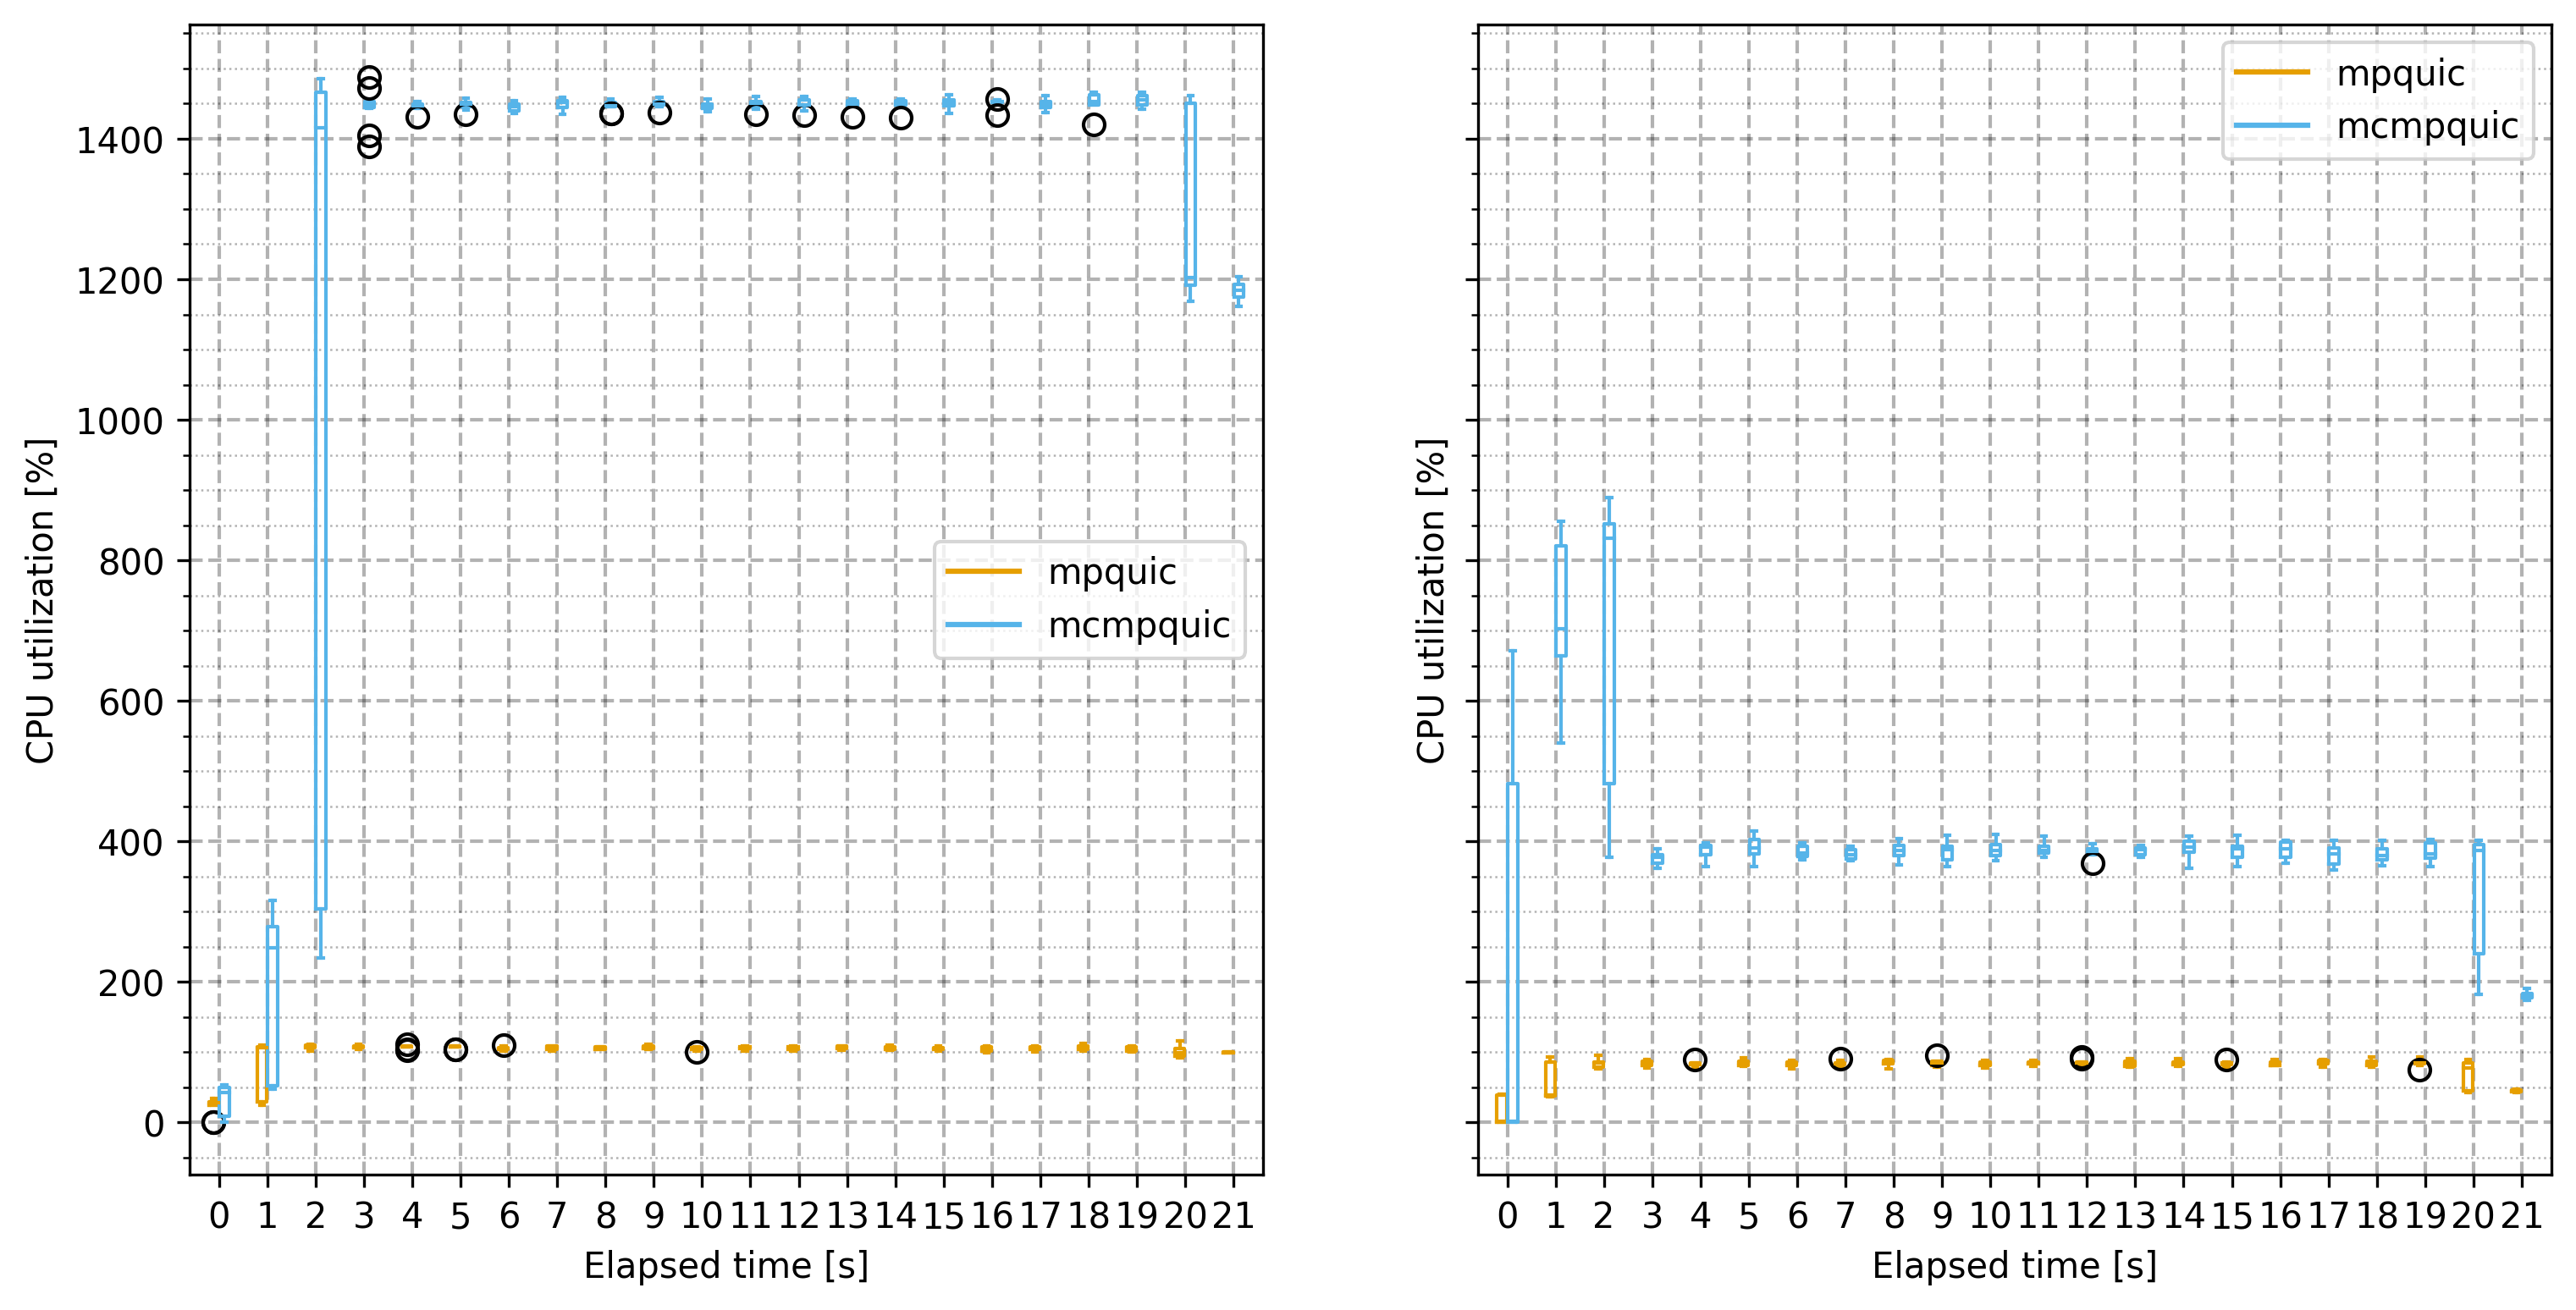

In [8]:
df_custom = df.loc[df["nb_paths"] == 16]
df_custom = df_custom.drop(columns=["nb_paths"], axis=1)
plot_cpu_util_per_sec(df_custom)

In [22]:
def axe_plot_cpu_util_per_sec(ax: plt.Axes, df: pd.DataFrame, title: str):
    """ Plot the CPU utilization of the client and server of an implementation
        nb_paths | cpu_util | implementation
    """
    implementations = sorted(list(df["implementation"].unique()), reverse=True)
    colors = [ my_utils.get_color_for_impl(impl) for impl in implementations ]
    all_nb_paths = list(df["nb_paths"].unique())
    all_nb_paths.sort()
    all_nb_paths = np.array(all_nb_paths)
    next_index = 0
    max_observed = 0
    for implementation in implementations:
        df_impl = df[df["implementation"] == implementation]
        subboxplot_data = []
        for nb_paths in all_nb_paths:
            cpu_util_values = df_impl[df_impl["nb_paths"] == nb_paths]["cpu_util"]
            cpu_util_values = cpu_util_values.to_numpy()
            subboxplot_data.append(cpu_util_values)
            if len(cpu_util_values) == 0: continue
            max_observed = max(max_observed, max(cpu_util_values))
        ax.scatter(all_nb_paths, subboxplot_data, label=implementation, color=colors[next_index], marker="*", zorder=3)
        next_index += 1
    
    ax.set_xticks(all_nb_paths, all_nb_paths)
    ax.set_xlabel("Number of paths")
    
    ax.grid(which='major', color='black', linewidth=.4, alpha=0.2, linestyle="dashed", zorder=3) # Show the major grid
    #ax.grid(which='minor', axis="y", color='black', linewidth=0.6, alpha=0.3, linestyle="dotted", zorder=3) # Show the major grid    
    ax.set_ylim(0)
    ax.legend(
        edgecolor='black', fancybox=False, shadow=False, framealpha=1,
    )
    #ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.set_title(title)
    ax.set_ylabel("CPU utilization [%]")
    
def plot_avg_cpu_util_per_path(df: pd.DataFrame, title: str):
    """ Plot the CPU utilization of the client and server of an implementation
        elapsed_secs | cpu_util | nb_paths | role | implementation
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=DPI, sharey=True)
    fig.subplots_adjust(hspace=0.5)
    client_df = df.loc[df["role"] == "client"]
    client_df = client_df.drop(columns=["role"], axis=1)
    client_df = client_df.groupby(["nb_paths", "implementation"])['cpu_util'].mean().reset_index()

    axe_plot_cpu_util_per_sec(axes[0], client_df, "Client")
    server_df = df.loc[df["role"] == "server"]
    server_df = server_df.drop(columns=["role"], axis=1)
    server_df = server_df.groupby(["nb_paths", "implementation"])['cpu_util'].mean().reset_index()

    fig.suptitle(title)
    
    axe_plot_cpu_util_per_sec(axes[1], server_df, "Server")
    axes[0].set_ylim(0, max(client_df["cpu_util"].max(), server_df["cpu_util"].max()) * 1.05)
    axes[1].set_ylim(0, max(client_df["cpu_util"].max(), server_df["cpu_util"].max()) * 1.05)

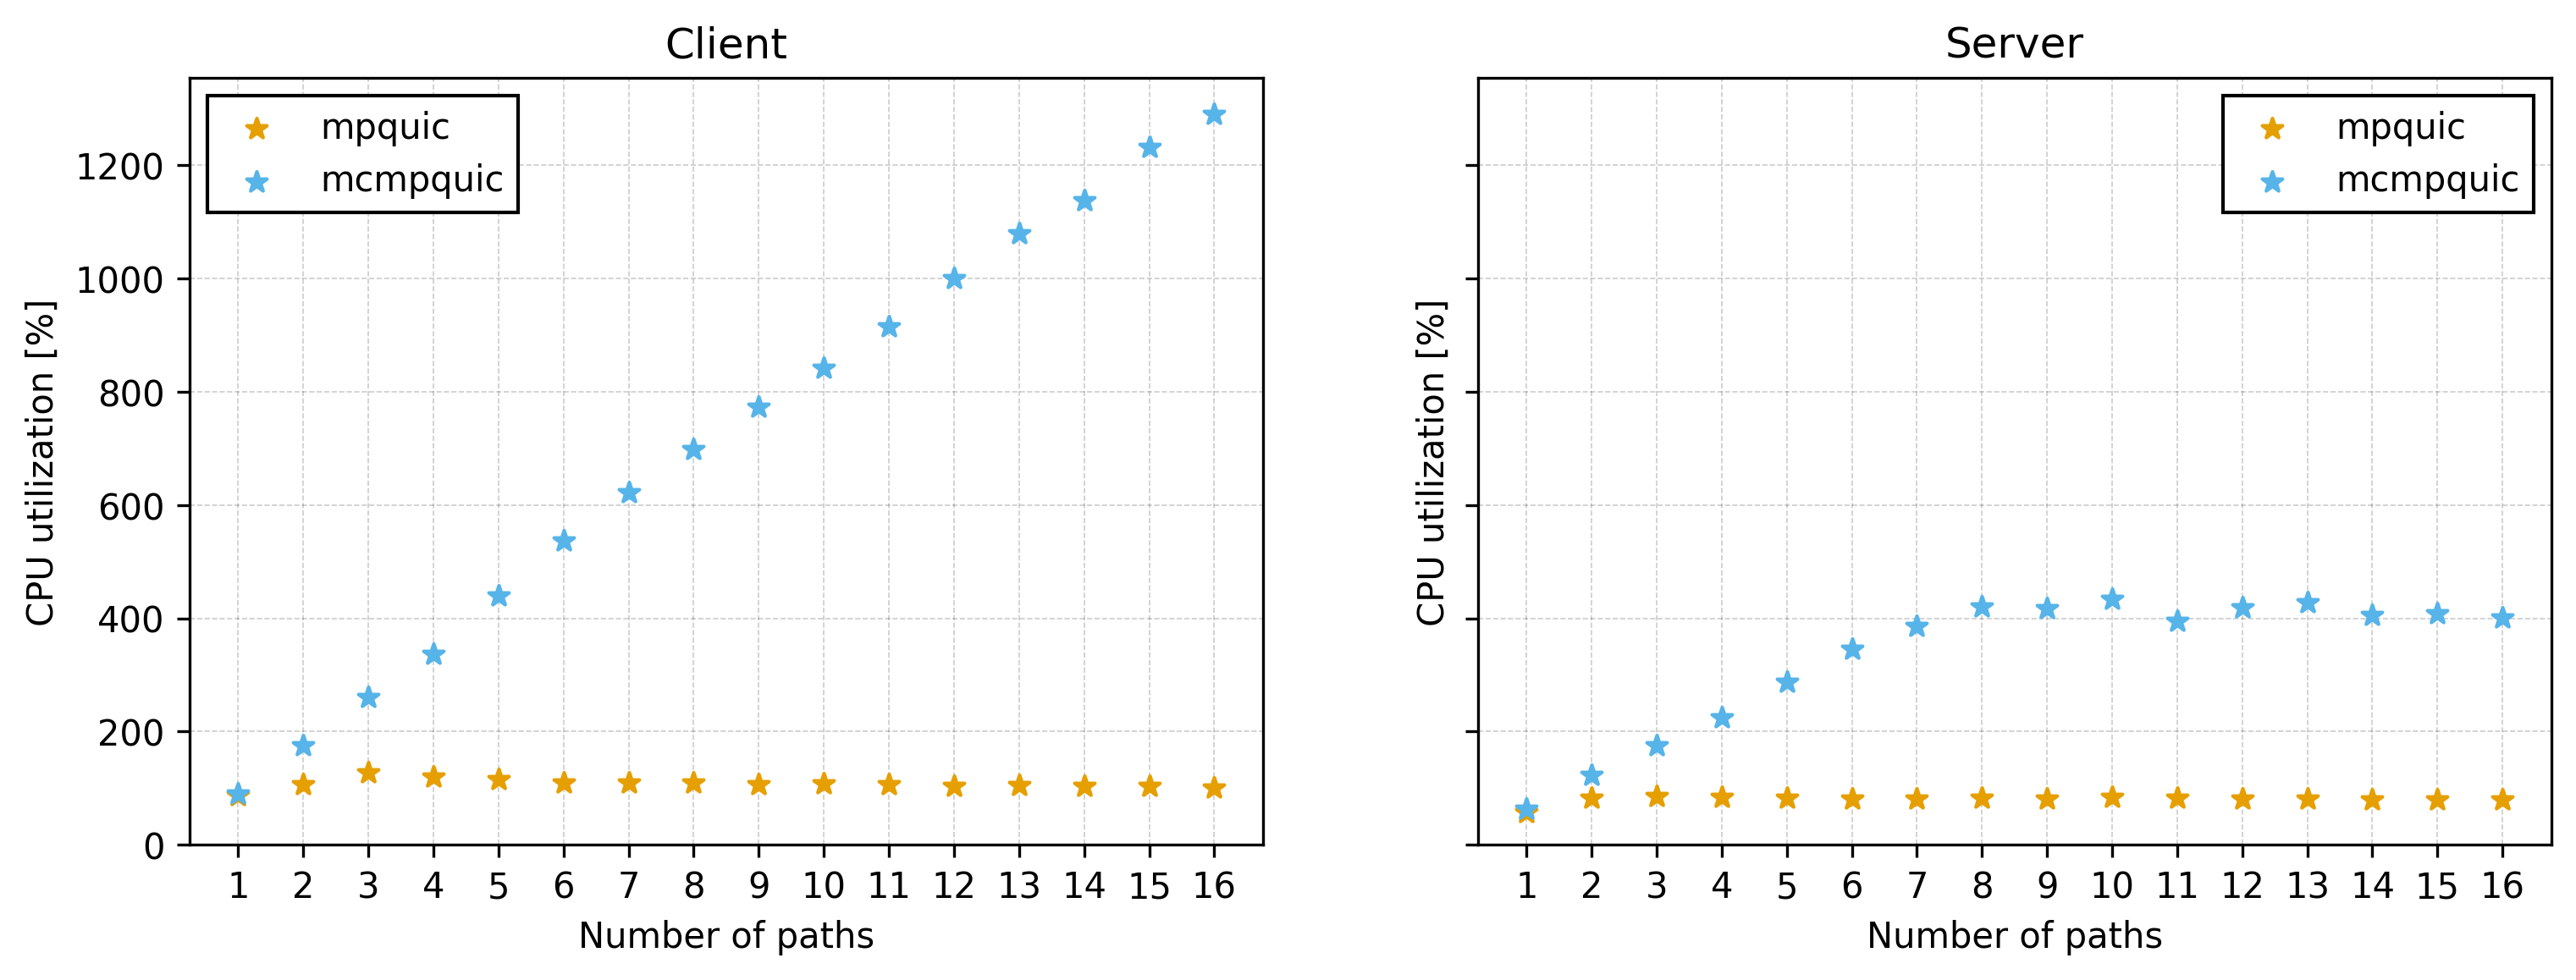

In [23]:
plot_avg_cpu_util_per_path(df, "")
plt.savefig(os.path.join(plots_directory, "cpu_util_per_nb_paths.pdf"), format="pdf", dpi=DPI, bbox_inches='tight')